# Test teacher reduced data

Is the teacher significantly worse with less data - does it make a difference if added data is from self-distillation or from real dataset?

## Importing section

In [1]:
import sys
sys.path.append('../')

In [2]:
from selfdist_toolkit.pyg_tools import gnn_load, GIN_nn, execution, sd_utils, accuracy
import pandas as pd
import torch
import torch_geometric
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import random

C:\Users\johan\anaconda3\envs\praktikum\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data loading - teacher

In [3]:
aid_list = pd.read_csv("../results/random_forest/experiments_check/chem-desc_good-aid_1.csv").aid.to_numpy().astype(int)

## Setup environment

In [4]:
# number epochs
epochs = 150

In [5]:
# random state where we want to set it
random_state = 131313

In [6]:
# hard mode - soft mode is actually deprecated
mode = "hard"

In [7]:
# batch size
batch_size = 100

In [8]:
# set percentage of training data to use
perc_train = 0.05

## Setting up storage location

In [9]:
# path for csv dataframe
csv_path = "../results/teacher_exp_data-reduced/csv/"
# path for graphs
graphs_path = "../results/teacher_data-reduced/graphs/"

In [10]:
# make sure the folder exists
if not os.path.exists(csv_path):
    os.makedirs(csv_path)
if not os.path.exists(graphs_path):
    os.makedirs(graphs_path)

## Iteration over assay ids and execution of teacher procedure

In [11]:
forbidden_aid=[686978]

In [12]:
for i, aid in enumerate(aid_list):

    # =================================================
    # Progress output
    # =================================================
    # print actual state
    print("current aid: {}, {}/{} - {:2.2%}".format(
        aid,
        i,
        aid_list.shape[0],
        i/aid_list.shape[0]
    ))

    # if experiment in forbidden experiments skip it
    if aid in forbidden_aid:
        print("skipped because in forbidden list")
        continue

    # =================================================
    # Load data
    # =================================================
    # load data for experiment
    whole_data = gnn_load.load_pyg_data_aid(aid=aid, label_type=mode, do_in_parallel=True, path_data="../data/")

    # get hard labels
    labels_hard = np.array([
        data.y.detach().cpu().numpy()
        for data in whole_data
    ]).flatten().astype(int)

    # do data splitting in train and test 80:20
    # data splitting
    for train_idx, test_idx in StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=0.2).split(whole_data, labels_hard):
        break

    # REDUCE TRAINING DATA TO 50%
    random.seed(random_state)
    train_idx = random.sample(train_idx.tolist(), int(perc_train*len(train_idx)))

    # generate the dataloader
    dl_train = torch_geometric.loader.DataLoader([whole_data[idx] for idx in train_idx], batch_size=batch_size)
    dl_test = torch_geometric.loader.DataLoader([whole_data[idx] for idx in test_idx], batch_size=batch_size)

    # =================================================
    # Model setup
    # =================================================
    # GNN model
    model = GIN_nn.GIN_basic(1)
    # loss
    loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(train_idx)/labels_hard[train_idx].sum()]))
    # device
    device = torch.device('cuda')
    model = model.to(device)
    loss = loss.to(device)
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # =================================================
    # Epoch iteration
    # =================================================
    # define loss saving space
    loss_storage = []

    # define accuracy storage
    accuracy_storage = []

    # epoch iterations
    for epoch in tqdm(range(epochs)):

        # do training step
        loss_value = execution.training(model, dl_train, device, optimizer, loss, verbose=False)

        # put loss into storage
        loss_storage.append(loss_value)

        # do testing step
        y_pred_hard = execution.predict(model, dl_test, device, reduce_to_hard_label=True, verbose=False)

        # calculate accuracy DataFrame
        accuracy_storage.append(
            # get accuracy class and from it the DataFrame
            accuracy.calculate_accuracies_1d(
                y_pred=y_pred_hard,
                y_true=accuracy.helper_pyg_to_numpy_label(
                    data_loader=dl_test
                )
            ).to_df(index=epoch)
        )

    # transform accuracy storage to pandas df
    accuracy_storage = pd.concat(accuracy_storage)

    # add new column for loss
    accuracy_storage['loss'] = loss_storage

    # =================================================
    # Save data to file
    # =================================================
    # set file path
    file_path = csv_path + "teacher-acc_aid={}_epochs={}.csv".format(aid, epochs)

    # write to file
    accuracy_storage.to_csv(file_path, index=True, index_label="epoch")

current aid: 884, 0/27 - 0.00%


100%|██████████| 150/150 [00:57<00:00,  2.60it/s]


current aid: 891, 1/27 - 3.70%


100%|██████████| 150/150 [00:49<00:00,  3.03it/s]


current aid: 899, 2/27 - 7.41%


100%|██████████| 150/150 [00:50<00:00,  2.95it/s]


current aid: 914, 3/27 - 11.11%


100%|██████████| 150/150 [00:45<00:00,  3.33it/s]


current aid: 1418, 4/27 - 14.81%


100%|██████████| 150/150 [00:08<00:00, 17.73it/s]


current aid: 1431, 5/27 - 18.52%


100%|██████████| 150/150 [00:09<00:00, 15.69it/s]


current aid: 1770, 6/27 - 22.22%


100%|██████████| 150/150 [00:09<00:00, 15.04it/s]


current aid: 1771, 7/27 - 25.93%


100%|██████████| 150/150 [00:08<00:00, 17.29it/s]


current aid: 1795, 8/27 - 29.63%


100%|██████████| 150/150 [00:08<00:00, 17.06it/s]


current aid: 493073, 9/27 - 33.33%


100%|██████████| 150/150 [00:09<00:00, 16.09it/s]


current aid: 493102, 10/27 - 37.04%


100%|██████████| 150/150 [00:09<00:00, 16.23it/s]


current aid: 493177, 11/27 - 40.74%


100%|██████████| 150/150 [00:09<00:00, 16.08it/s]


current aid: 493191, 12/27 - 44.44%


100%|██████████| 150/150 [00:09<00:00, 15.57it/s]


current aid: 493240, 13/27 - 48.15%


100%|██████████| 150/150 [00:09<00:00, 16.46it/s]


current aid: 588834, 14/27 - 51.85%


100%|██████████| 150/150 [00:21<00:00,  6.95it/s]


current aid: 651741, 15/27 - 55.56%


100%|██████████| 150/150 [00:08<00:00, 17.22it/s]


current aid: 651812, 16/27 - 59.26%


100%|██████████| 150/150 [00:13<00:00, 10.76it/s]


current aid: 651814, 17/27 - 62.96%


100%|██████████| 150/150 [00:09<00:00, 15.03it/s]


current aid: 686978, 18/27 - 66.67%
skipped because in forbidden list
current aid: 687022, 19/27 - 70.37%


100%|██████████| 150/150 [00:09<00:00, 15.53it/s]


current aid: 720691, 20/27 - 74.07%


100%|██████████| 150/150 [00:35<00:00,  4.28it/s]


current aid: 743036, 21/27 - 77.78%


100%|██████████| 150/150 [00:32<00:00,  4.58it/s]


current aid: 743040, 22/27 - 81.48%


100%|██████████| 150/150 [00:35<00:00,  4.21it/s]


current aid: 743065, 23/27 - 85.19%


100%|██████████| 150/150 [00:33<00:00,  4.46it/s]


current aid: 1053173, 24/27 - 88.89%


100%|██████████| 150/150 [00:10<00:00, 14.24it/s]


current aid: 1259381, 25/27 - 92.59%


100%|██████████| 150/150 [00:34<00:00,  4.29it/s]


current aid: 1346982, 26/27 - 96.30%


100%|██████████| 150/150 [00:32<00:00,  4.55it/s]


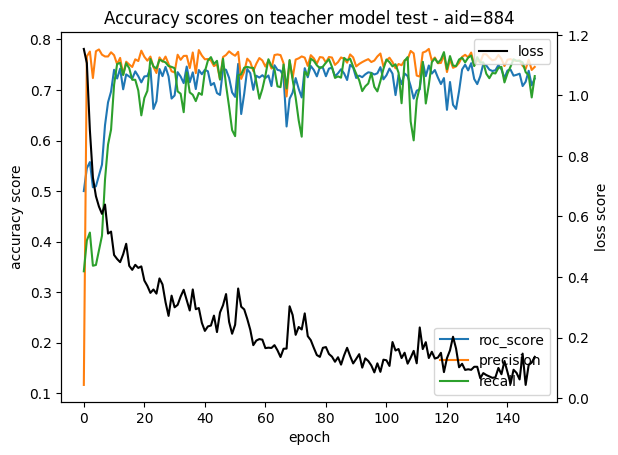

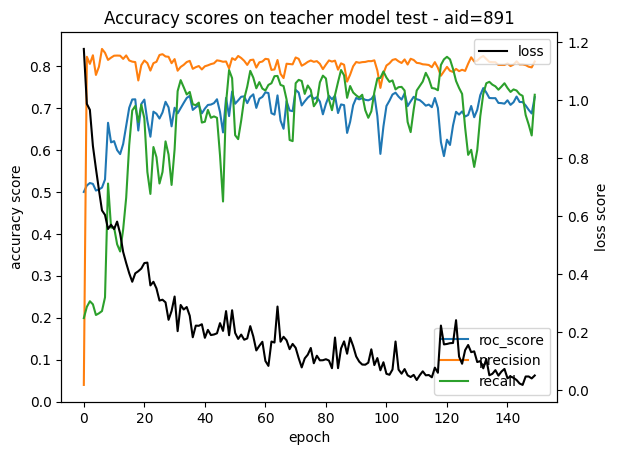

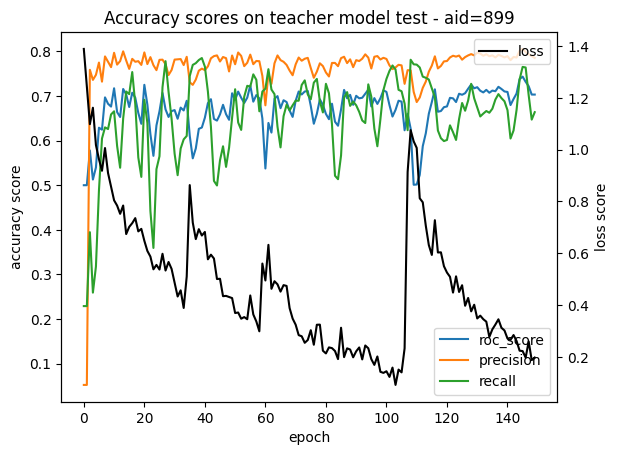

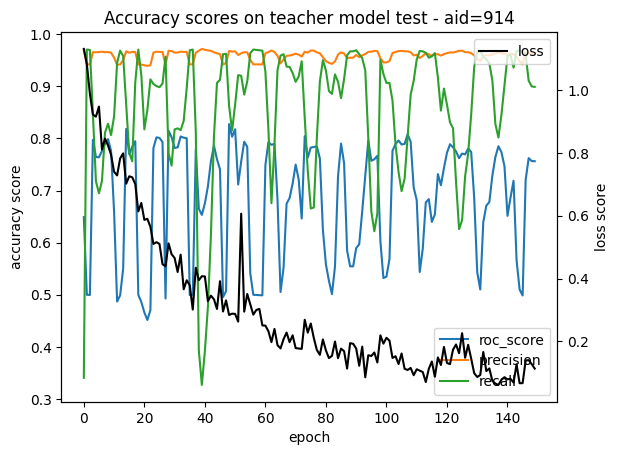

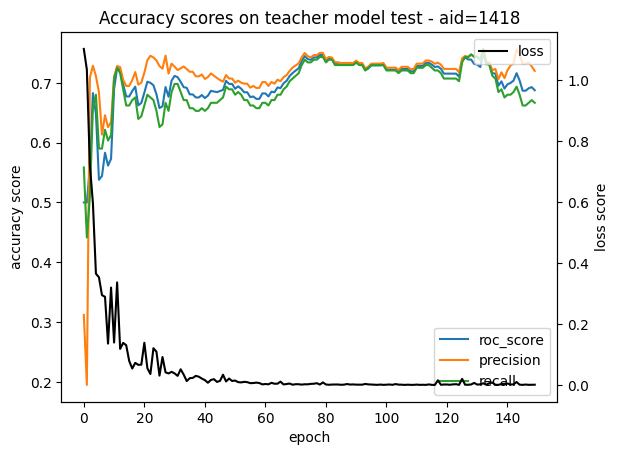

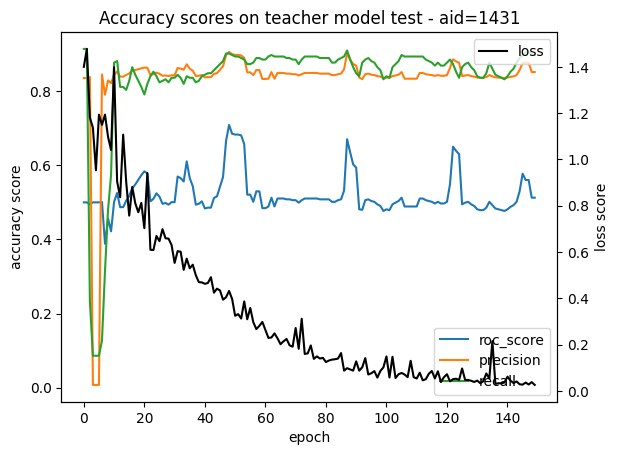

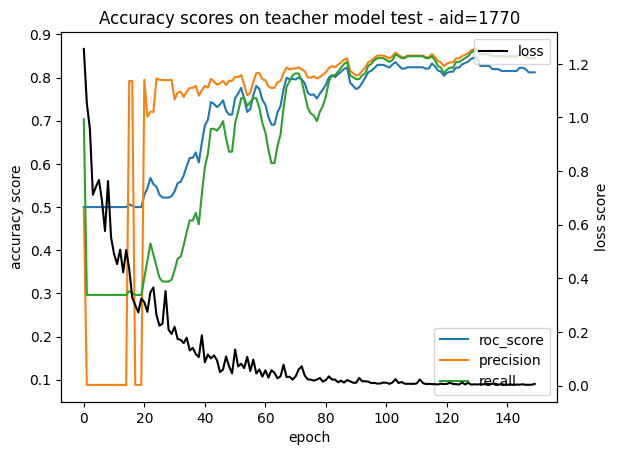

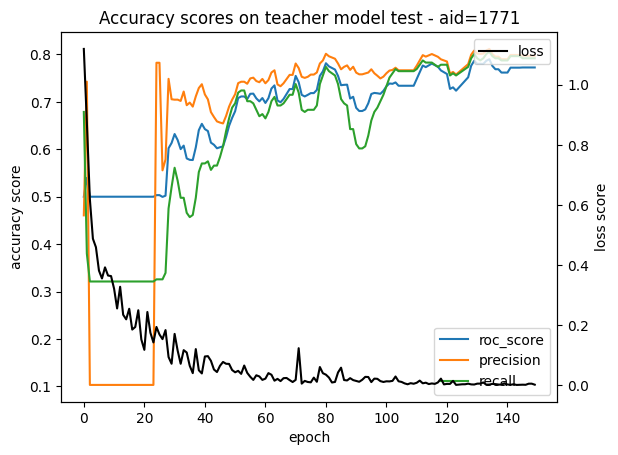

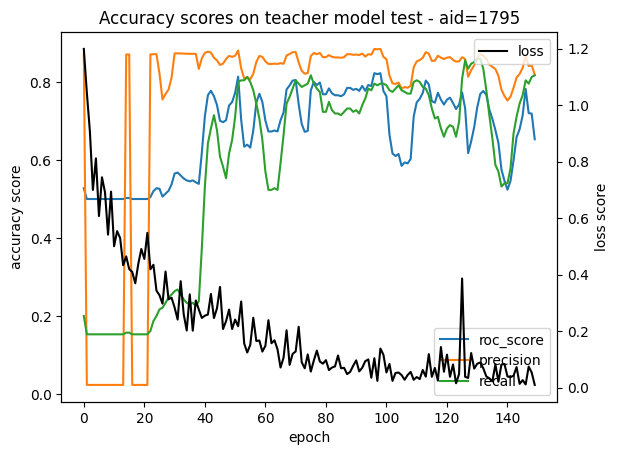

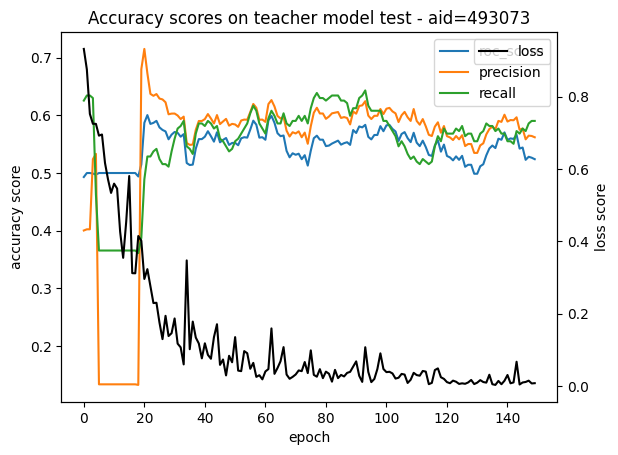

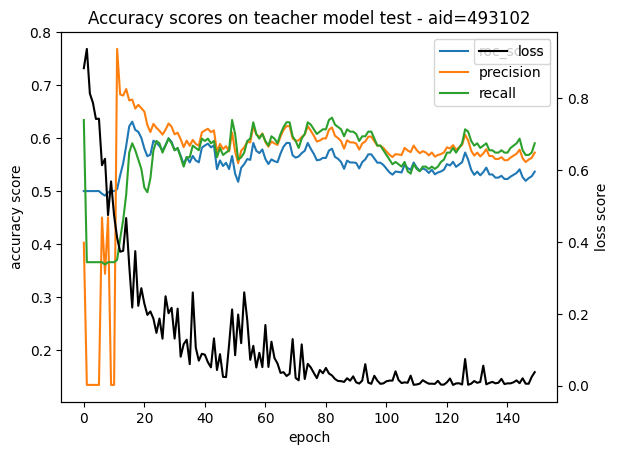

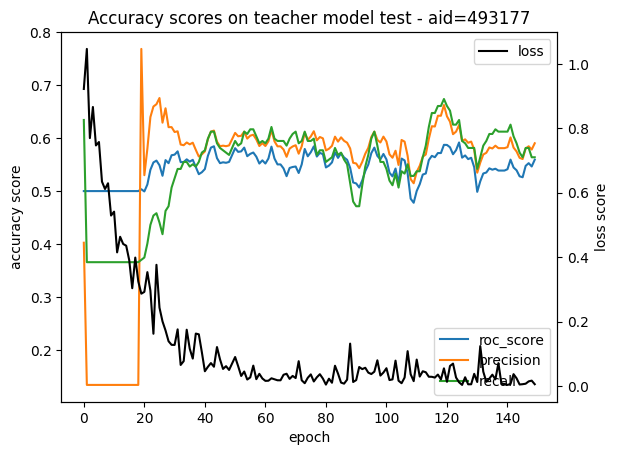

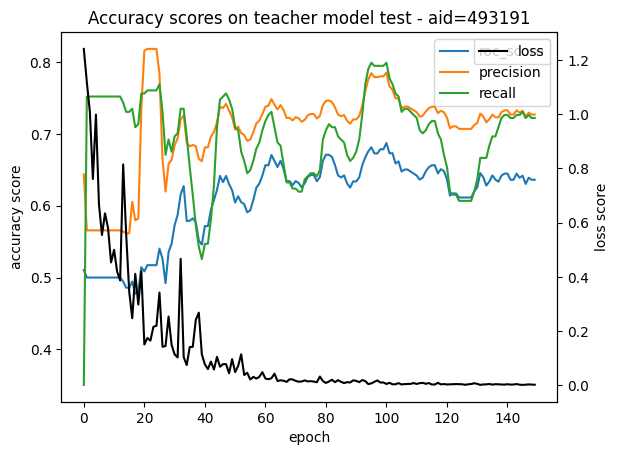

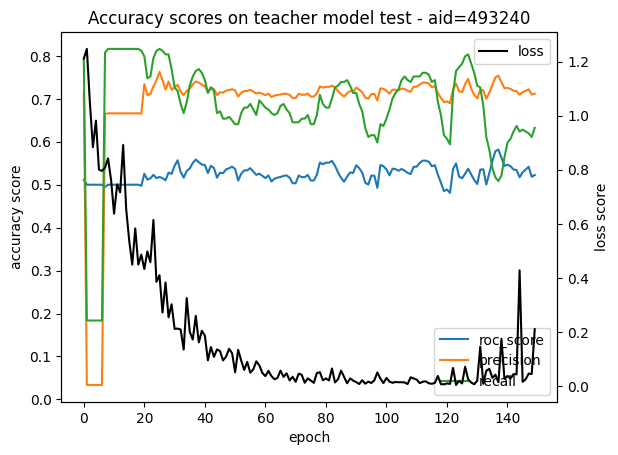

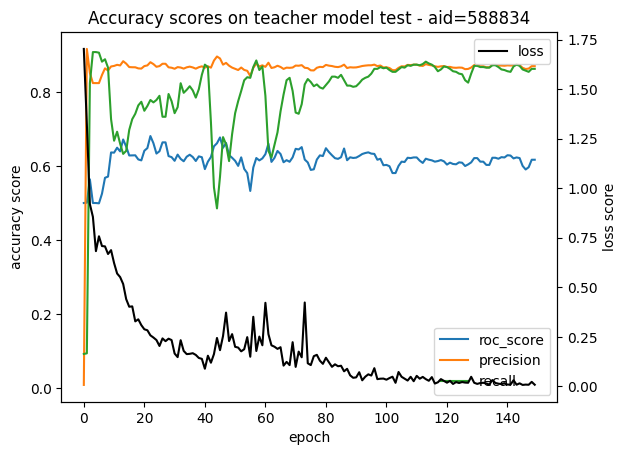

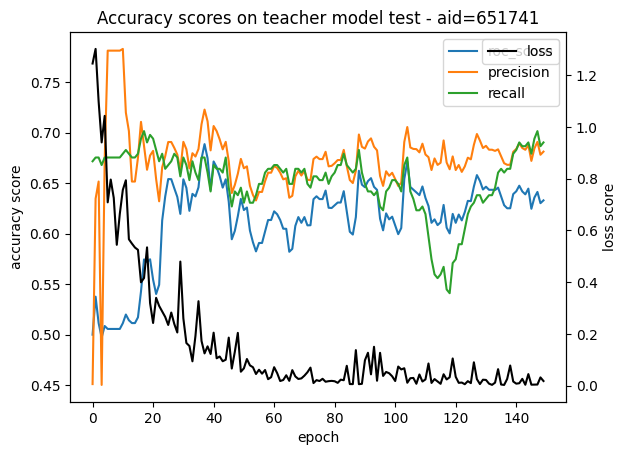

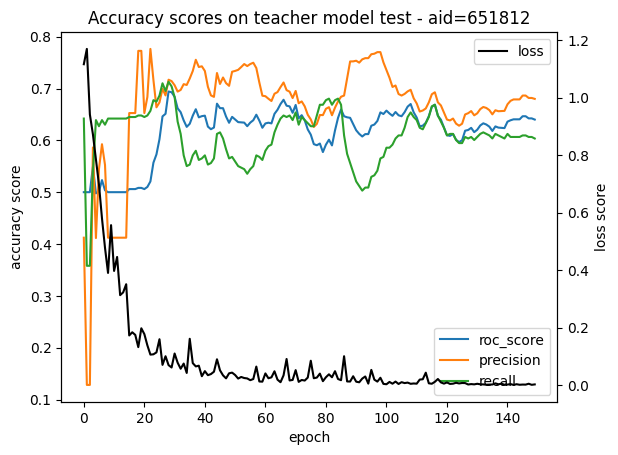

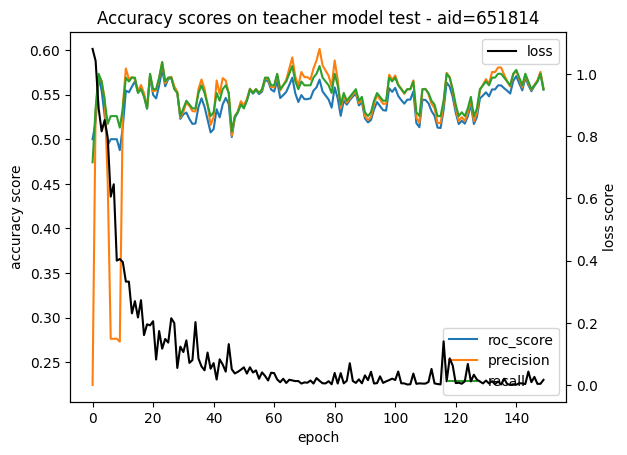

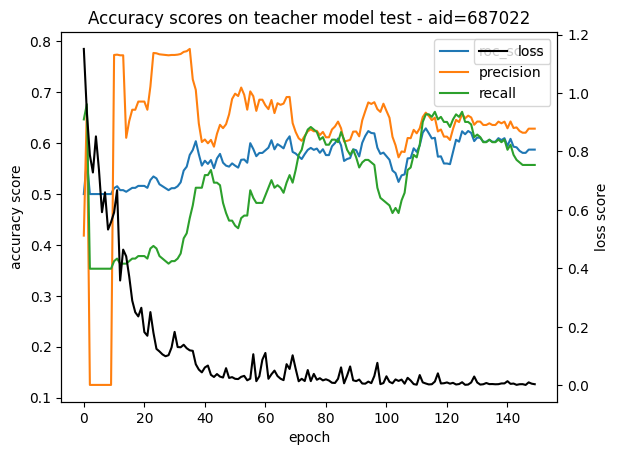

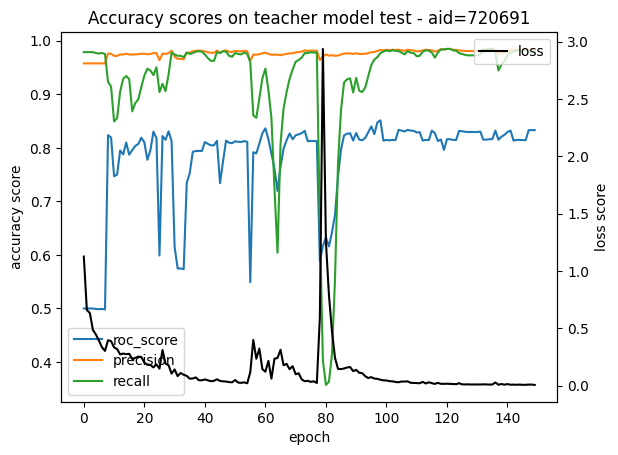

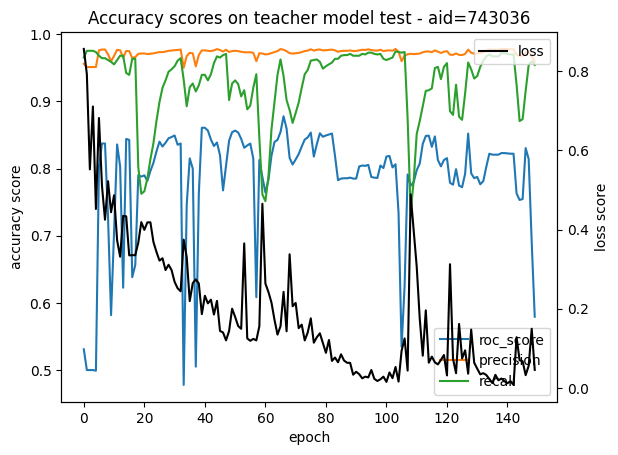

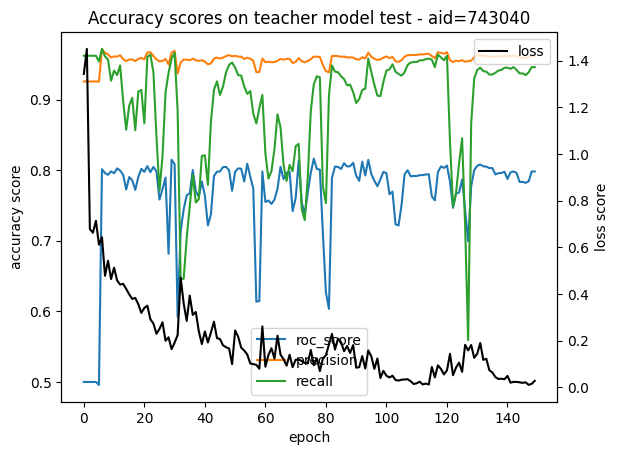

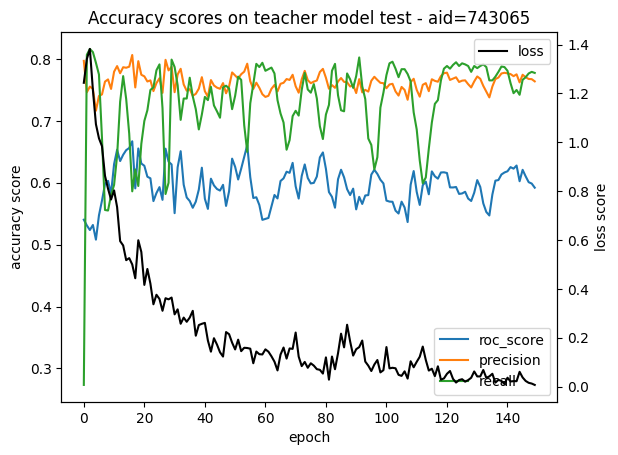

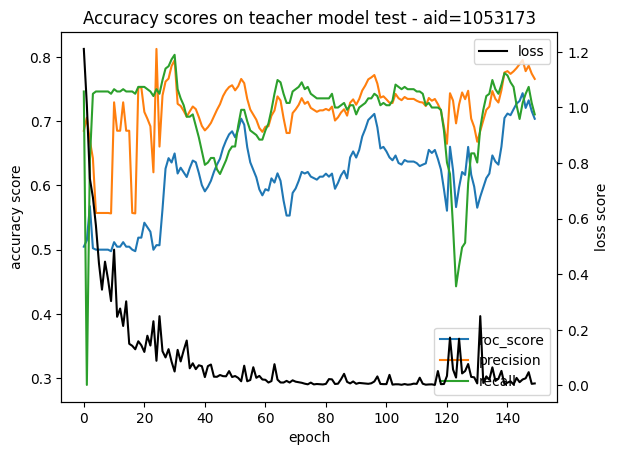

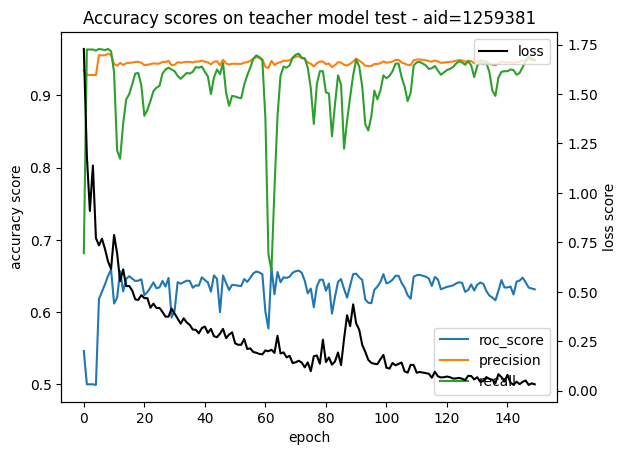

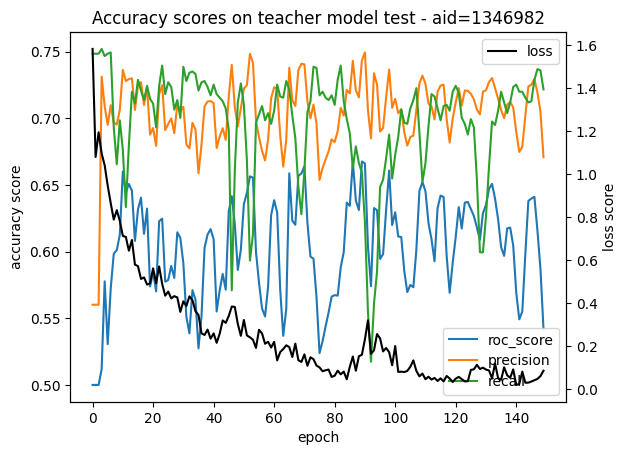

In [13]:
for aid in aid_list:

    # if experiment in forbidden experiments skip it
    if aid in forbidden_aid:
        continue

    # determine storage location of csv
    file_path = csv_path + "teacher-acc_aid={}_epochs={}.csv".format(aid, epochs)

    # determine storage location of image
    file_path_plot = graphs_path + "TeacherAccs_aid-{}_epochs-{}.png".format(aid, epochs)

    # load the csv
    loaded_csv = pd.read_csv(file_path, index_col="epoch")

    # plotting
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loaded_csv.roc_score, label="roc_score")
    ax1.plot(loaded_csv.precision, label="precision")
    ax1.plot(loaded_csv.recall, label="recall")
    ax2.plot(loaded_csv.loss, color="black", label="loss")

    ax1.set_xlabel("epoch")
    ax1.set_ylabel("accuracy score")
    ax2.set_ylabel("loss score")
    ax1.legend()
    ax2.legend()
    plt.title("Accuracy scores on teacher model test - aid={}".format(aid))
    plt.savefig(file_path_plot, bbox_inches='tight')
    plt.show()